In [1]:
import models
from models import model, create_cd_cluster, cd_diagram, bt_plot
from dataset_management import get_dataset, convert_to_autorank
from autorank import autorank, create_report, plot_stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

algorithm="algorithm";benchmark="bench_prior";seed="seed";budget="used_fidelity"
ds=get_dataset(dataset_name="fig5_24_at25_bad_intsteps")

P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
Model failed to converge with max|grad| = 0.00327793 (tol = 0.002, component 1) 

P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 

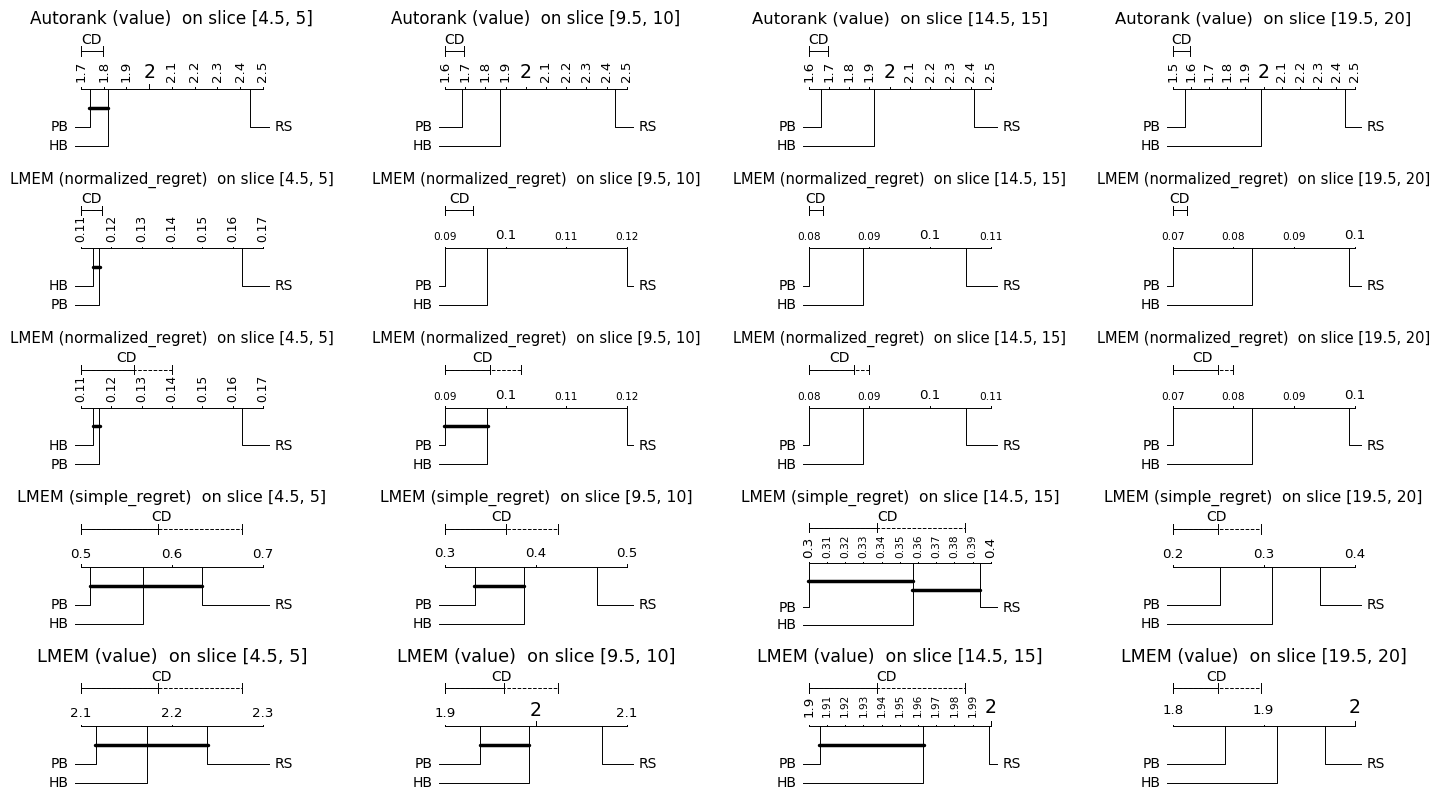

In [2]:
plot_1=bt_plot(slices=[[5],[10],[15],[20]],rows=5,dataset=ds,algorithm_var=algorithm,budget_var=budget)
plot_1.change_row(0,None,globality=False,loss="value")
# plot_1.change_row(1,f"{algorithm}",globality=False,loss="rel_rank")
plot_1.change_row(1,f"{algorithm}+(1|{benchmark})",globality=False,loss="normalized_regret")
plot_1.change_row(2,f"{algorithm}+({algorithm}|{benchmark})",globality=False,loss="normalized_regret") # Reproduces Autorank
plot_1.change_row(3,f"{algorithm}+({algorithm}|{benchmark})",globality=False,loss="simple_regret")
plot_1.change_row(4,f"{algorithm}+({algorithm}|{benchmark})",globality=False,loss="value")

plot_1.show()


P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 

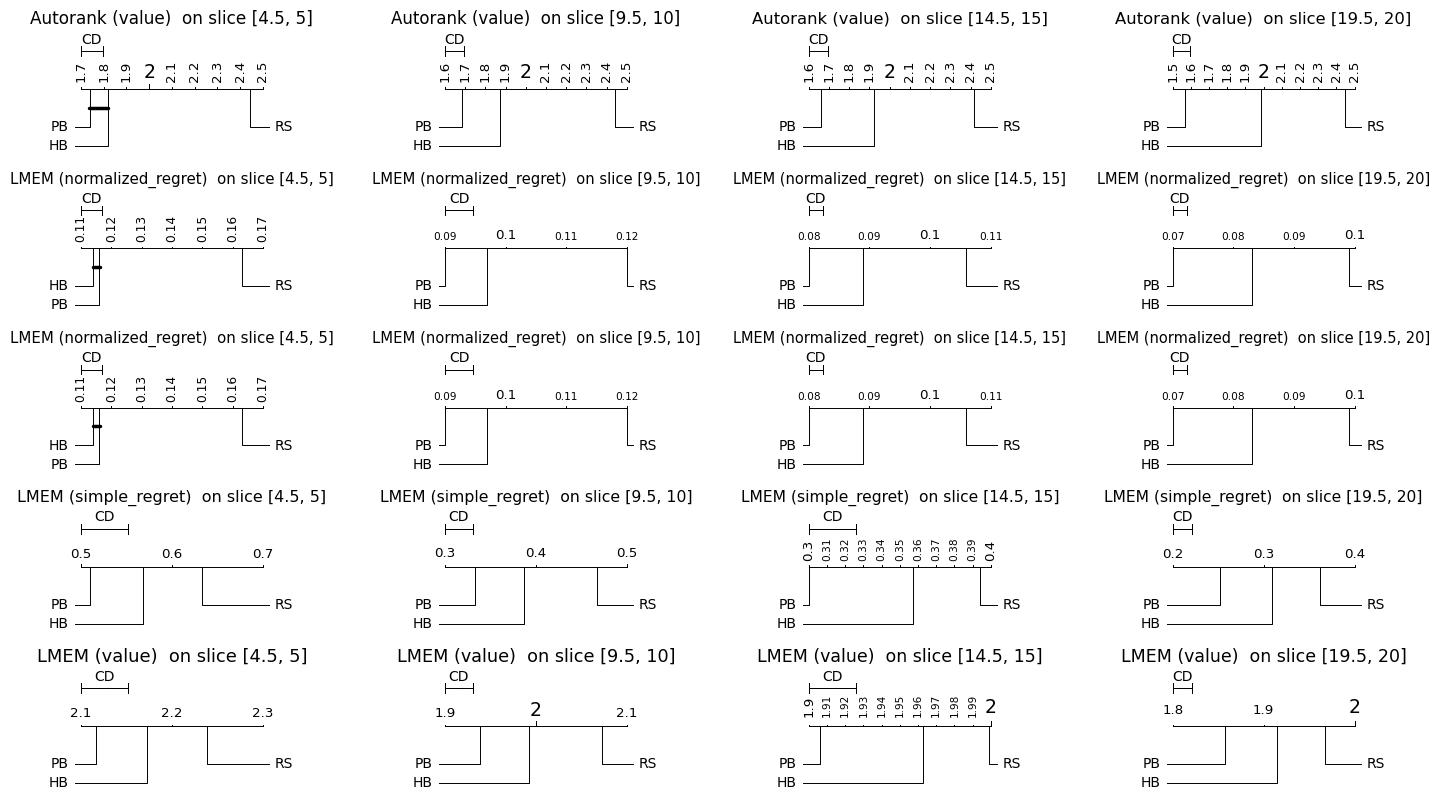

In [3]:
plot_1=bt_plot(slices=[[5],[10],[15],[20]],rows=5,dataset=ds,algorithm_var=algorithm,budget_var=budget)
plot_1.change_row(0,None,globality=False,loss="value")
# plot_1.change_row(1,f"{algorithm}",globality=False,loss="rel_rank")
plot_1.change_row(1,f"{algorithm}+(1|{benchmark})",globality=False,loss="normalized_regret")
plot_1.change_row(2,f"{algorithm}+{algorithm}:{benchmark}",globality=False,loss="normalized_regret") # Reproduces Autorank
plot_1.change_row(3,f"{algorithm}+{algorithm}:{benchmark}",globality=False,loss="simple_regret")
plot_1.change_row(4,f"{algorithm}+{algorithm}:{benchmark}",globality=False,loss="value")

plot_1.show()

boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates


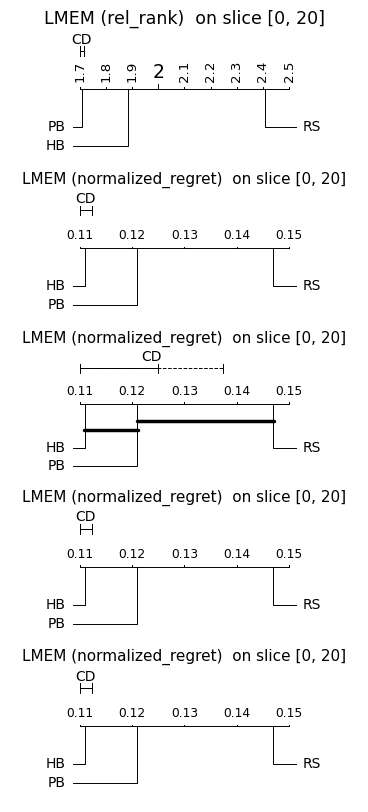

In [4]:
plot_2=bt_plot(slices=[[0,20]],rows=5,dataset=ds,algorithm_var=algorithm,budget_var=budget)
plot_2.change_row(0,f"{algorithm}",globality=False,loss="rel_rank")
plot_2.change_row(1,f"{algorithm}+{budget}+{algorithm}:{budget}+(1|{benchmark})",globality=False,loss="normalized_regret")
plot_2.change_row(2,f"{algorithm}+{budget}+{algorithm}:{budget}+({algorithm}|{benchmark})",globality=False,loss="normalized_regret")
plot_2.change_row(3,f"{algorithm}+{budget}+{algorithm}:{budget}+{algorithm}:{benchmark}",globality=False,loss="normalized_regret")
plot_2.change_row(4,f"{algorithm}+{budget}+{algorithm}:{budget}+{algorithm}:{benchmark}+(1|{benchmark})",globality=False,loss="normalized_regret")
plot_2.show()

P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates


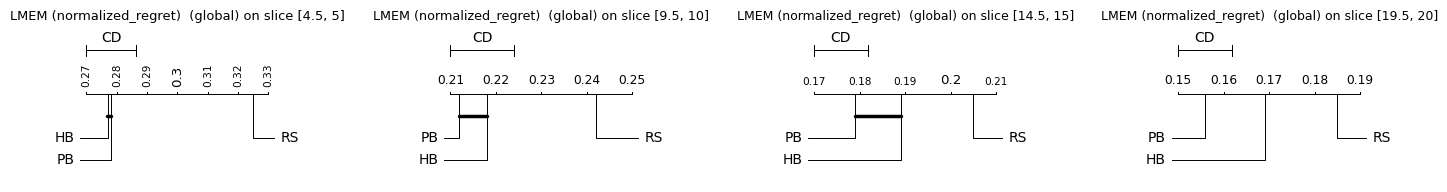

In [5]:
plot_3=bt_plot(slices=[[5],[10],[15],[20]],rows=1,dataset=ds,algorithm_var=algorithm,budget_var=budget)
plot_3.change_row(0,f"{algorithm}+{budget}+(1|{benchmark})",globality=True,loss="normalized_regret")
plot_3.show()